## Required Installations and Imports

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score


from art.attacks.evasion import FastGradientMethod
from art.estimators.classification import SklearnClassifier

## Baseline Models 


=== Logistic Regression ===
              precision    recall  f1-score   support

      attack       0.92      0.62      0.74     12833
      normal       0.65      0.93      0.76      9711

    accuracy                           0.75     22544
   macro avg       0.78      0.77      0.75     22544
weighted avg       0.80      0.75      0.75     22544



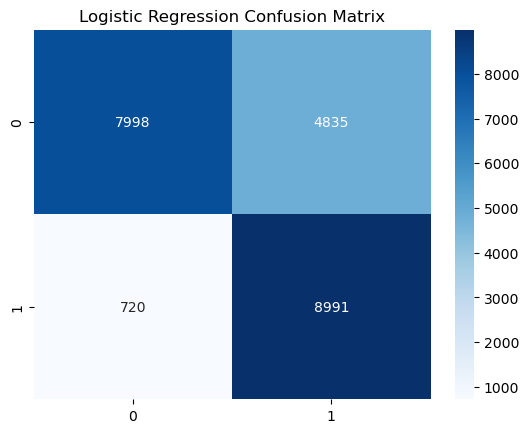


=== Random Forest ===
              precision    recall  f1-score   support

      attack       0.97      0.61      0.75     12833
      normal       0.65      0.97      0.78      9711

    accuracy                           0.77     22544
   macro avg       0.81      0.79      0.77     22544
weighted avg       0.83      0.77      0.76     22544



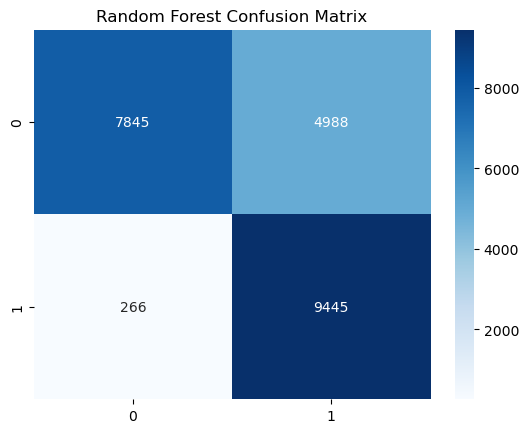


Baseline accuracies:
Logistic Regression: 0.7536
Random Forest: 0.7669


In [ ]:
# Loading data
train_path = 'data/KDDTrain+.TXT'
test_path = 'data/KDDTest+.TXT'

# Define column names (41 features + label + difficulty)
columns = [
    'duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes',
    'land', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'logged_in',
    'num_compromised', 'root_shell', 'su_attempted', 'num_root', 'num_file_creations',
    'num_shells', 'num_access_files', 'num_outbound_cmds', 'is_host_login', 'is_guest_login',
    'count', 'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate',
    'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count',
    'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate',
    'dst_host_srv_diff_host_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate',
    'dst_host_rerror_rate', 'dst_host_srv_rerror_rate', 'label', 'difficulty']

# Load datasets
train_df = pd.read_csv(train_path, names=columns)
test_df = pd.read_csv(test_path, names=columns)

# cleaning and binary labeling
for df in [train_df, test_df]:
    df.drop('difficulty', axis=1, inplace=True)
    df['binary_label'] = df['label'].apply(lambda x: 'normal' if x == 'normal' else 'attack')

# feature/target split
X_train = train_df.drop(['label', 'binary_label'], axis=1)
y_train = train_df['binary_label']
X_test = test_df.drop(['label', 'binary_label'], axis=1)
y_test = test_df['binary_label']

# preprocessing pipeline

categorical_features = ['protocol_type', 'service', 'flag']
numeric_features = [col for col in X_train.columns if col not in categorical_features]

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numeric_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
])

# baseline models

models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42)
}

results = {}

for name, model in models.items():
    clf = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', model)])
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    results[name] = acc
    print(f'\n=== {name} ===')
    print(classification_report(y_test, y_pred))
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
    plt.title(f'{name} Confusion Matrix')
    plt.show()

print("\nBaseline accuracies:")
for name, acc in results.items():
    print(f"{name}: {acc:.4f}")


## FGSM adversarial attack on Logistic Regression


Logistic Regression Accuracy on clean test set: 0.7539
Logistic Regression Accuracy on adversarial test set: 0.2408


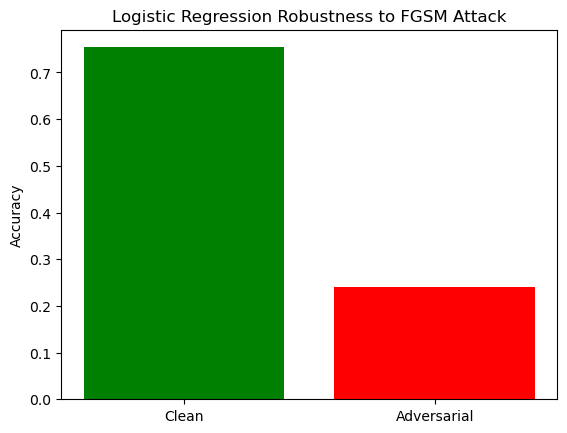

In [8]:
# Choose LR for FGSM
chosen_model = LogisticRegression(max_iter=1000)

# Preprocess data
X_train_prepared = preprocessor.fit_transform(X_train)
X_test_prepared  = preprocessor.transform(X_test)
y_train_binary = (np.array(y_train) == 'attack').astype(int)
y_test_binary  = (np.array(y_test) == 'attack').astype(int)
y_train_onehot = to_categorical(y_train_binary, nb_classes=2)

# Wrap LR for ART
clip_min = X_train_prepared.min()
clip_max = X_train_prepared.max()
art_clf = SklearnClassifier(model=chosen_model, clip_values=(clip_min, clip_max))

# Fit ART classifier
art_clf.fit(X_train_prepared, y_train_onehot)

# Generate adversarial examples
attack = FastGradientMethod(estimator=art_clf, eps=0.1)
X_adv = attack.generate(x=X_test_prepared)

# Evaluate LR on clean and adversarial examples
preds_clean = np.argmax(art_clf.predict(X_test_prepared), axis=1)
preds_adv   = np.argmax(art_clf.predict(X_adv), axis=1)
acc_clean = np.mean(preds_clean == y_test_binary)
acc_adv   = np.mean(preds_adv == y_test_binary)

print(f"\nLogistic Regression Accuracy on clean test set: {acc_clean:.4f}")
print(f"Logistic Regression Accuracy on adversarial test set: {acc_adv:.4f}")

plt.bar(['Clean', 'Adversarial'], [acc_clean, acc_adv], color=['green', 'red'])
plt.title('Logistic Regression Robustness to FGSM Attack')
plt.ylabel('Accuracy')
plt.show()



FGSM cannot be directly used on Random Forest. This is because FGSM is a **gradient-based** attack. It needs for the model to be **differentiable**, because it's computing the loss with respect to the input features, to know how to perturbate them. Since Logistic Regression is differentiable, then FGSM is a valid attack on it.

In regards to Random Forest, how the attack works doesn't match how the model works, so this can't be used.
Random Forest is **non-differentiable** because it's made of decision trees, which uses discrete splits. There's no gradient for FGSM to compute.

Although FGSM cannot be applied to Random Forest, it serves as a baseline to provide a **non-linear comparison** and demonstrate **model diversity** and **robustness**, even though gradient-based attacks like FGSM can't be applied on it.

RF helps us understand how, some models (non-differentiable ones), are naturally resistant to gradient-based attacks. This is relevant in the context of our discussion about adversarial ML. 

In addition, RF allows us to compare its accuracy with LR on the clean test, and verify that our data preprocessing and pipeline are correct. This helps us verify that our dataset and models behave as expected. In our case LR and RF have reasonale baseline accuracies (about 75-77%).

This helps provide context for the effect of the adversarial attack and see the drop in LR accuracy even though we can see that RF still performs well on clean data.